<font face = "Calibri"><font size = 4>
## **AirBNB Rio de Janeiro Data**  

Some facts:

- "Airbnb, Inc. is an American company that operates an online marketplace for lodging, primarily homestays for vacation rentals, and tourism activities." _Wikipedia_;  
- 2020 and 2021 were terrible years to travel and difficult moments for who rent by Airbnb. However, it seems that 2022 things will return to certain level of normality;  
- One of most desired city to travel is Rio de Janeiro. Beautiful city owned a lot of natural beauties and full of receptive people.   

The company provide to public samples of its data.
In this notebook, data from Rio de Janeiro city were downloaded from this link: http://insideairbnb.com/get-the-data.html  

Specifically, these were the three datasets for this work:  

- listings_id: http://data.insideairbnb.com/brazil/rj/rio-de-janeiro/2021-09-28/data/listings.csv.gz  
- calendar: http://data.insideairbnb.com/brazil/rj/rio-de-janeiro/2021-09-28/data/calendar.csv.gz  
- reviews: http://data.insideairbnb.com/brazil/rj/rio-de-janeiro/2021-09-28/data/reviews.csv.gz  

The objective here it is to analyze the datasets and explore three subjects:  
1. For future months, will there <b>any tendency for booking</b>?  
2. Both Brazilians and foreigners love to travel to Rio. But <b>has Brazilians different neighborhood preference</b> for stay?
3. Price is a key factor in bookings. <b>But what matters for the price value?</b> What features of accommodations most impact?  


In [33]:
# Libaries and loading datasets
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np

import langdetect

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score

warnings.filterwarnings('ignore')

# Setting a good theme for seaborn
sns.set_theme(style="darkgrid")

# Reading datasets
list_df = pd.read_csv('../database/listings.csv')
calendar_df = pd.read_csv('../database/calendar.csv')
# review_df = pd.read_csv('./database/reviews.pip csv')
review_df = pd.read_csv('../database/reviews_with_lang.csv', usecols=[1,2,3,4,5,6,7])

***

<font face="Calibri"><font size= 4>
# 1. For future months, will there <b>any tendency for booking</b>?  

The main dataset to work with is the calendar_df.  
Data in this dataset is a list of accommodations and the booking for the next one year.  
  
The main idea here is to create a dataframe of demand.  
To analyze the occupation rate, it was considered 'f' value for available column

In [2]:
# Just necessary columns and new name
demand_df = calendar_df[['listing_id', 'date', 'available']]

# Create a list of months and create a column in dataframe, 
# so that it will be possible analyze by month.
months = pd.date_range(start=demand_df.date.min(), end=demand_df.date.max(), periods=13, normalize=True).strftime('%b %y')
demand_df['month_year'] = pd.DatetimeIndex(demand_df.date).strftime('%b %y')

# Rule: if the id is available, so it is not occupied
demand_df['occupied'] = demand_df.available.map({'f':1, 't':0})

# Group data by month, taking the average of day occupied
# The mean of 1 (ones, occupied) represent the rate of 
# occupied days in month
occupied_df = demand_df.groupby(by=['month_year']).mean()[['occupied']]

# Sep 21 has only three days, so its mean is greater than others. So, take it off
occupied_df = occupied_df.drop('Sep 21')

<font face="Calibri"><font size= 4>
Ok, with occupied_df ready, it's time to plot some columns and see if there's a tendency

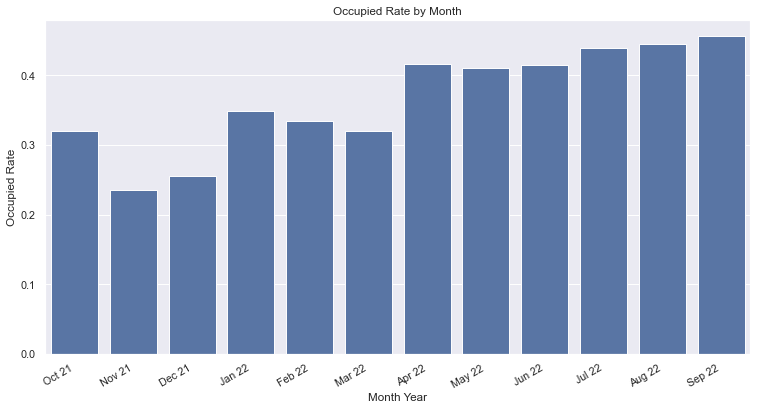

In [3]:
# Plotting the occupied rate by month
sns.barplot(x=occupied_df.index, y=occupied_df.occupied, order=months[1:], color='b')
f, ax = plt.gcf(), plt.gca()
f.set(dpi=70, size_inches=(13,7)); f.autofmt_xdate()
ax.set(xlabel='Month Year', ylabel='Occupied Rate', title='Occupied Rate by Month')
plt.show()

<font face="Calibri"><font size= 4>

It's seems that the occupied rate is bigger next year.  
This could represent the returning of tourism activity after COVID pandemic.  
People are confident about next year, so we see almost 45% of occupation in Rio.  

Important to note that rate raises in January and fall until March. In spite of Carnaval in March, January attract more tourists because it's summer time in the city.

<font face="Calibri"><font size= 4>

In Rio, there are a lot of famous neighborhoods, as Copacabana and Ipanema.  
After this first look in demand, the question appears: I wonder if any of neighborhood could show different demand?

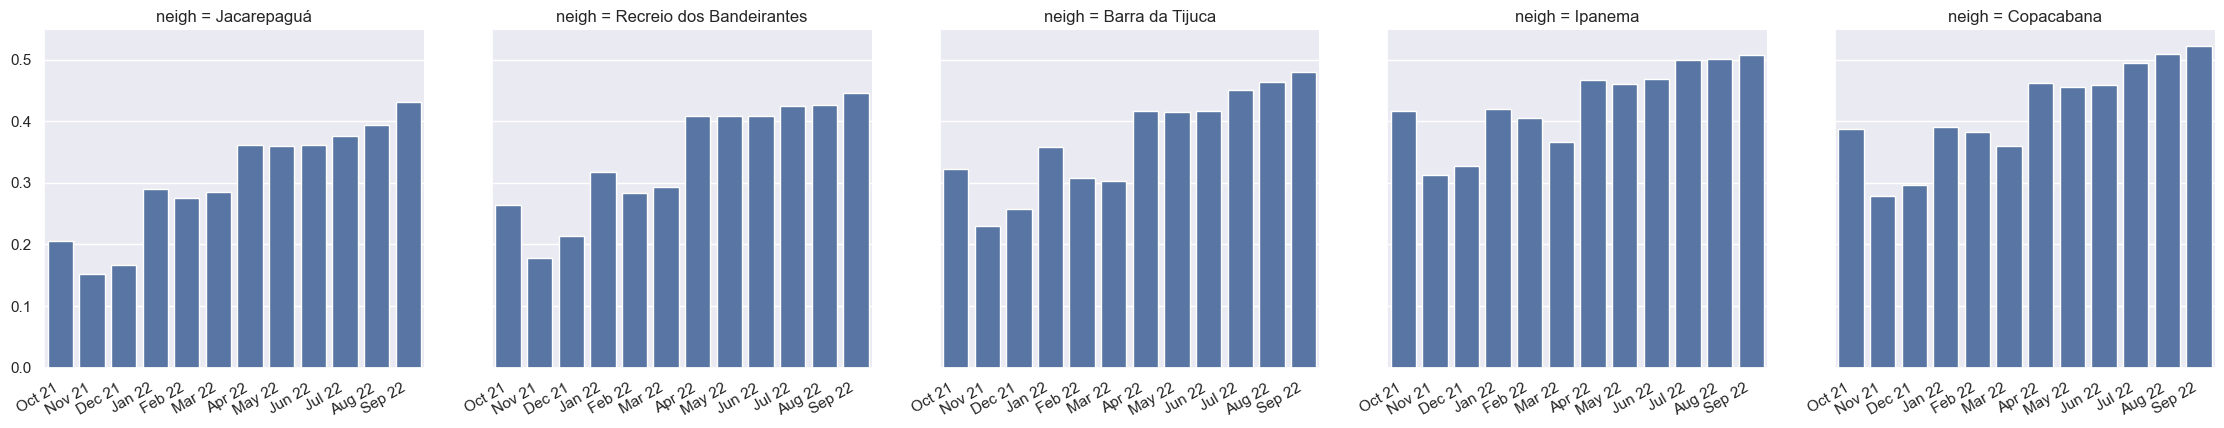

In [4]:
# Creating a dataframe with neighborhoods of each listing id
neighborhood_list_df = list_df[['id','neighbourhood_cleansed']].\
                             rename({'neighbourhood_cleansed':'neigh'}, axis=1)

# Merge two dataframes
demand_w_neigh_df = demand_df.merge(neighborhood_list_df, left_on='listing_id', right_on='id')

# Grouping the dataframe by month and neighborhood. 
# Taking the average of occupied days
occupied_w_neigh_df = demand_w_neigh_df.groupby(['month_year','neigh']).mean()[['occupied']]

# By having a lot of neighborhood, it's better filter the
# top five neighborhood in quantity of listing
top_5_neigh = demand_w_neigh_df.groupby(['neigh']).agg({'id':lambda x: x.nunique()}).\
                                sort_values('id')[-5:].index.to_list()
demand_w_neigh_df = demand_w_neigh_df[demand_w_neigh_df.neigh.isin(top_5_neigh)]

# Creating an auxiliary dataframe to analyses the occupation in top 5
df_aux = demand_w_neigh_df.groupby(['month_year','neigh']).\
                           agg({'occupied':'mean','id':lambda x: x.nunique()}). \
                           assign(occu_ind=lambda x: x['occupied']*x['id']).\
                           sort_values('occu_ind').\
                           reset_index()

# Again, ignore September 2021
df_aux = df_aux[df_aux['month_year'] != 'Sep 21']

# Plotting the occupation rate by neighborhood
g = sns.FacetGrid(data=df_aux, col="neigh")
g.map_dataframe(sns.barplot, x='month_year', y='occupied', order=months[1:], color='b' )
f, ax = plt.gcf(), plt.gca()
f.set(dpi=100, size_inches=(23,5)); f.autofmt_xdate()
# ax.set(xlabel='Month and Year', ylabel='Occupied Rate', title='Occupied Rate by Month\nSomething is related to COVID pandemic')
plt.show()

<font face="Calibri"><font size= 4>

Top 5 neighborhoods with accommodation are a great sample of famous ones.  
The samples in the graphs are Copacabana, Ipanema, Barra da Tijuca, Recreio and Jacarepaguá.  

But columns it is not an effective way to see different tendencies.  
Let's plot lines



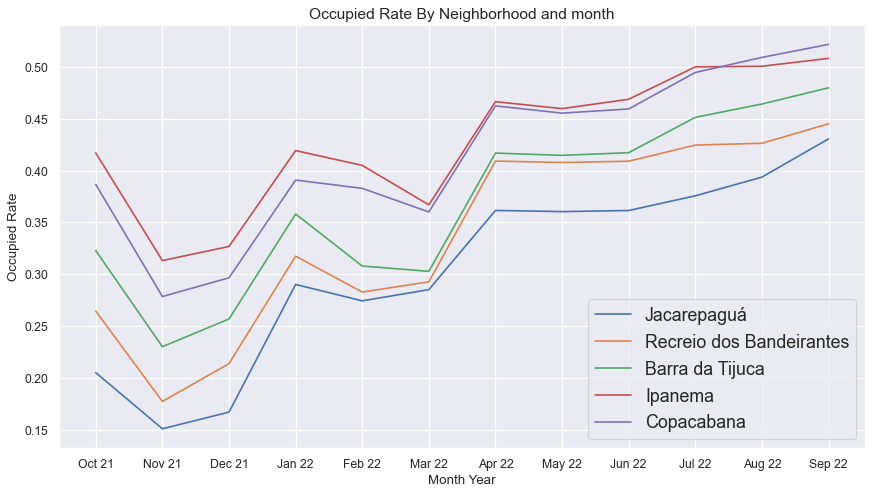

In [5]:
# Plotting in lines
df_aux['month_year_ord'] = pd.Categorical(df_aux.month_year, categories=months, ordered=True)
df_aux.sort_values('month_year_ord')

plt.figure(figsize=(13,7), dpi=80)
sns.lineplot(data=df_aux, x='month_year_ord', y='occupied',hue='neigh', legend='full')
plt.xlabel('Month Year')
plt.ylabel('Occupied Rate')
plt.title('Occupied Rate By Neighborhood and month', fontdict={'fontsize':14})
plt.legend(loc='lower right', fontsize=16)
plt.show()

<font face="Calibri"><font size= 4>

By the lines, it's seen that Ipanema and Copacabana has higher occupation rate in comparison with other neighborhoods within entire period. This is because of the great fame of these places.  

- Dec 2021 and Jan 2022  
By final of 2021, the rate is lower. As spoken before, in January the rate increase because <b>summer</b>.  
- Feb and Mar 2022  
In February the occupation rate falls, as in March, except to Recreio dos Bandeirantes and Jacarepaguá neighborhoods.   
This could be effect of biggest event in Rio, <b>Carnaval</b>. It will take place in begin of March 2022.   
Thus, end of February and begin of March receive a good demand and after event, get down.  
- Apr to Jun 2022  
In this period the rate grows substantial and maintains a certain level, without any considerable forward movement.
- Jul to Sep 2022  
By July and forward, there is an interesting rate of growing. The explanation is the second biggest event in Rio de Janeiro: <b>Rock in Rio</b>. In 2022 it will happen in the begin of September 2022, in Barra Olympic Park, in Barra da Tijuca. It seen in the graph that this neighborhood has good occupation rate in this period. 
The local of event is closer to Jacarepaguá, what explain its rate to get higher from 0.31 to 0.425 in three months, the biggest grow rate.  
The other neighborhood next is Recreio dos Bandeirantes that has a great grow in September too.



---

<font face="Calibri"><font size = 4>
# 2. Both Brazilians and foreigners love to travel to Rio. But <b>has Brazilians different neighborhood preference</b> for stay?

This time, reviews dataset is used.  
Important to note that there's not any country identification neither in calendar nor review datasets.  
To get this information, the language of comments will be considered.
I have conscious that foreign could use Portuguese to comment a house in Brazil. But this assumption is taken here to enable the analysis.  

So, with language detected, and Portuguese ate labeled as been Brazilians and other languages are considered foreign.

In [6]:
def lang_dectection(text):
    '''
    Using language detection to identify 
    the country of reviewer
    INPUT
        text: text to detect the language
    OUTPUT
        language of text

    '''
    if isinstance(text, str):
        try:
            return langdetect.detect(text)
        except:
            return np.nan
    else:
        return np.nan

# Detecting the language 
# review_df['lang'] = review_df.comments.map(lambda x: lang_dectection(x) )
review_df['nationality'] = review_df.lang.map({'pt':'brazilian'}).fillna('foreign')

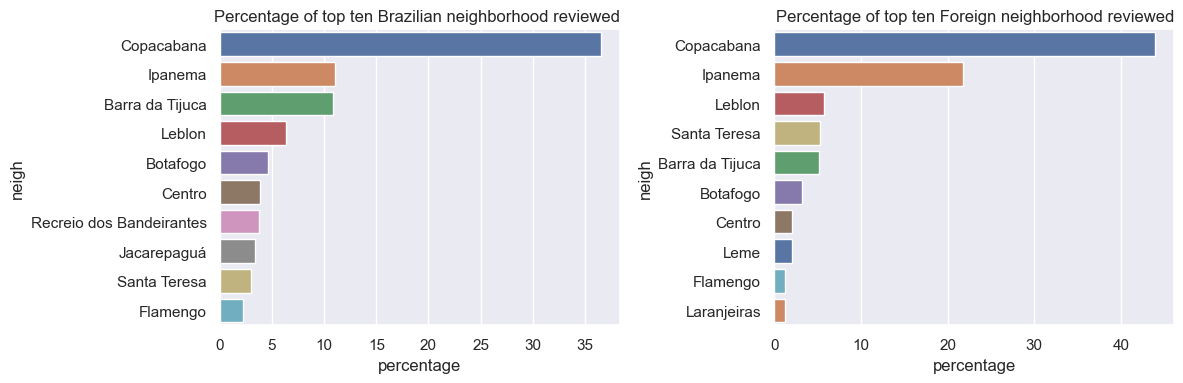

In [7]:
# Creating a dataframe merging the review dataset with neighborhood list
review_w_neigh = review_df.merge(neighborhood_list_df, left_on='listing_id', right_on='id')

# Grouping the dataframe to counting the reviewer by neighborhood
nat_neigh = review_w_neigh.groupby(['nationality','neigh']).\
                           agg(percentage=('neigh', 'count')).\
                           groupby(level=0).apply(lambda x: (x/x.sum())*100).\
                           sort_values(['nationality', 'percentage']).\
                           rename({'neigh':'per'}, axis=1).\
                           reset_index()
                            
# Plotting the top 10 places by nationality
br = nat_neigh[nat_neigh.nationality=='brazilian'].sort_values('percentage',ascending=False)[:10].round(2)
fo = nat_neigh[nat_neigh.nationality=='foreign'].sort_values('percentage',ascending=False)[:10].round(2)
# Setting colors to y_labels
lbls = pd.concat([br.neigh, fo.neigh]).drop_duplicates() 
colors = sns.color_palette(n_colors=len(lbls))
colors = dict(zip(lbls,colors))

f, ax = plt.subplots(1,2, dpi=100)

sns.barplot(data=br, x='percentage', y='neigh', palette=colors, ax=ax[0])
sns.barplot(data=fo, x='percentage', y='neigh', palette=colors, ax=ax[1])
ax[0].set_title('Percentage of top ten Brazilian neighborhood reviewed', loc='right')
ax[1].set_title(f'Percentage of top ten Foreign neighborhood reviewed',loc='right')
f.set_size_inches(12,4); f.tight_layout()
plt.show()

<font face="Calibri"><font size= 4>

Copacabana and Ipanema keep top 2 position in preference for both nationalities.  
The difference is with third. It looks like Brazilians prefer Barra da Tijuca to Leblon. For Brazilians, Barra da Tijuca has a better fame, since it is considered luxury neighborhood whereas foreign is turned more for tourism.  
This is evident for the next position. Foreigners has considerable preference to Santa Teresa in comparison with Brazilians. Santa Teresa is the local of Christ the Redeemer statue, once chosen one of seven wonders of the world. For Brazilians, this seems the neighborhood is not a good place to stay. A lot of it prefer other good and comfortable neighborhoods and just visit the statue.


---

<font face="Calibri"><font size=4>
# 3. Price is a key factor in bookings. <b>But what influence its value?</b> What features of accommodations are most important?  
  
The main factor of choose an accommodation is the combination of quality, matching guest necessity and the most important, price.  
When these three points show for the costumer, it is a great chance for booking.  

In sight of it, this last data treatment tries to predict the value for booking based on by features of accommodation and host, like review scores and number of beds, for example.  

Here, the listing dataset is used, and some steps are necessary to clean and prepare data to work with prediction.


In [8]:
# First, it is necessary to clean dataframe from empties columns

# It was noted that same columns are just URLs. So, it was decided to exclude these too
urls = list_df.columns.str.contains('_url') 
list_df = list_df.loc[:, list_df.columns[~urls]]

# Checking for emptiness in the columns
# For price column
list_df.price.isna().sum()

0

<font face='Calibri'><font size = 4>
Everything's ok wih main column

In [9]:
# Empties of other columns
columns_emptiness = list_df.isna().sum()/list_df.shape[0]
columns_emptiness_df = pd.Series(columns_emptiness, name='emptines')
print (
pd.cut(columns_emptiness_df, 
       bins=np.arange(0,1.1,0.1)).value_counts(normalize=True).round(2) * 100
)
columns_emptiness_df.sort_values(ascending=False).head(14)

(0.3, 0.4]    38.0
(0.0, 0.1]    38.0
(0.9, 1.0]    12.0
(0.4, 0.5]     9.0
(0.5, 0.6]     3.0
(0.8, 0.9]     0.0
(0.7, 0.8]     0.0
(0.6, 0.7]     0.0
(0.2, 0.3]     0.0
(0.1, 0.2]     0.0
Name: emptines, dtype: float64


bathrooms                       1.000000
neighbourhood_group_cleansed    1.000000
license                         1.000000
calendar_updated                1.000000
host_about                      0.507175
neighborhood_overview           0.455924
neighbourhood                   0.455924
host_neighbourhood              0.445887
review_scores_location          0.375715
review_scores_checkin           0.375673
review_scores_accuracy          0.375673
review_scores_value             0.375630
review_scores_cleanliness       0.375630
review_scores_communication     0.375587
Name: emptines, dtype: float64

<font face = "Calibri"><font size=4>

Unfortunately, the columns of reviews scores have big proportion of empties.  
The limit to not drop these columns is approximately 40% emptiness.  
This limit will be used, so that the influence of review score impact on price could be study.


In [10]:
# Select the columns with less than 40% of emptiness
list_df_selc_col = list_df.loc[:, list_df.columns[columns_emptiness < 0.4]]

# There are numeric columns and string columns
list_df_selc_col.dtypes.value_counts()

object     24
int64      21
float64    16
dtype: int64

In [11]:
# It's important analyze the string columns, since some of are useless
list_df_selc_col.describe(include='O').T.sort_values('unique')

,count,unique,top,freq
host_has_profile_pic,23396,2,t,23285
has_availability,23414,2,t,23378
host_identity_verified,23396,2,t,15697
host_is_superhost,23396,2,f,18749
instant_bookable,23414,2,f,15447
last_scraped,23414,3,2021-09-29,14278
calendar_last_scraped,23414,3,2021-09-29,14278
host_response_time,15821,4,within an hour,6346
room_type,23414,4,Entire home/apt,17118
bathrooms_text,23344,51,1 bath,9479


In [12]:
# As seen, columns like name and description are useless for
# regression, because both the number of unique is large and
# the variable is not cause of price variance.

# This time, the columns dtype date are deleted also. It could
# be used for further analysis, but in this time, it will be excluded.

# Some columns need to be transformed after in the right type, like
# host_response_rate and price

remain_string_cols = [
    'host_has_profile_pic', 'host_identity_verified','host_is_superhost', 
    'instant_bookable', 'host_response_time', 'room_type', 'host_response_rate',
    'host_acceptance_rate', 'neighbourhood_cleansed', 'price'
    ]


# Regarding numeric columns, it should have good variability
# to contribute to regression 
# The evaluation is made
list_df_selc_col.describe().T

,count,mean,std,min,25%,50%,75%,max
id,23414.0,2.641178e+07,1.665127e+07,1.787800e+04,1.242405e+07,2.618998e+07,4.193944e+07,5.249405e+07
scrape_id,23414.0,2.021093e+13,0.000000e+00,2.021093e+13,2.021093e+13,2.021093e+13,2.021093e+13,2.021093e+13
host_id,23414.0,1.042743e+08,1.142081e+08,3.607000e+03,1.427959e+07,6.037972e+07,1.594694e+08,4.245700e+08
host_listings_count,23396.0,8.844290e+00,3.220531e+01,0.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00,5.890000e+02
host_total_listings_count,23396.0,8.844290e+00,3.220531e+01,0.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00,5.890000e+02
latitude,23414.0,-2.296591e+01,3.535148e-02,-2.307262e+01,-2.298465e+01,-2.297192e+01,-2.295090e+01,-2.274969e+01
longitude,23414.0,-4.324844e+01,9.682269e-02,-4.369889e+01,-4.330301e+01,-4.319613e+01,-4.318612e+01,-4.310440e+01
accommodates,23414.0,4.124840e+00,2.482795e+00,0.000000e+00,2.000000e+00,4.000000e+00,5.000000e+00,1.600000e+01
bedrooms,21895.0,1.707422e+00,1.133174e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,4.700000e+01
beds,23206.0,2.552960e+00,2.288561e+00,0.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,9.100000e+01


In [13]:
# A lot of columns seem not to cause a great impact on price,
# like host_listing_count, latitude and others.

remain_num_cols = [
       'accommodates','bedrooms', 'beds', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 
       'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location', 
       'review_scores_value', 'reviews_per_month'
       ]

# Union of selected columns 
remain_cols = remain_num_cols + remain_string_cols
# Filtering the columns in the dataframe
list_df_selc_col = list_df_selc_col.loc[:, remain_cols]

# Get the string values to numeric values
def str_to_num_percentage(df, col):
       '''
       Convert string percentage to numeric
       INPUT
              df: dataframe
              col: column with string percentage to convert
       OUTPUT
              dataframe with converted column
       '''
       try:
              df[col] = df[col].str.extract('(.*)\%')
              df[col] = pd.to_numeric(df[col], downcast='float')
       except:
              pass
       return df[col]

def str_to_num_money(df, col):
       '''
       Convert string money to numeric
       INPUT
              df: dataframe
              col: column with string money to convert
       OUTPUT
              dataframe with converted column
       '''
       try:
              df[col] = df[col].str.extract('^\$(.*)')
              df[col] = df[col].str.replace(',','')
              df[col] = pd.to_numeric(df[col], downcast='float')
       except:
              pass
       return df[col]

# Converting the values
list_df_selc_col.price = str_to_num_money(list_df_selc_col, 'price')
list_df_selc_col.host_response_rate = str_to_num_percentage(list_df_selc_col, 'host_response_rate')
list_df_selc_col.host_acceptance_rate = str_to_num_percentage(list_df_selc_col, 'host_acceptance_rate')

In [14]:
# Now, it's time to dummies string variables. But the neighborhood has
# 53 possible values. So, it's necessary to create a parallel metric
# to use neighborhood information
# Here, it will be created 4 cluster of neighborhoods. This would be a
# problem for new data, since new neighborhood would come in. But,
# for this purpose, this will be used.

# The metric to cluster the neigh was number of accommodations
neigh_clusters = list_df_selc_col.groupby('neighbourhood_cleansed').\
                                  agg(count=('neighbourhood_cleansed', 'count'))
# Using sklearn k_means function to create the clusters
from sklearn.cluster import k_means
neigh_clusters['neighbourhood_cluster'] = k_means(neigh_clusters.values, n_clusters=4)[1]
neigh_clusters = neigh_clusters.reset_index()[['neighbourhood_cleansed','neighbourhood_cluster' ]]

# Merge back with original dataframe
list_df_selc_col = list_df_selc_col.merge(neigh_clusters, on='neighbourhood_cleansed').\
                                    drop(columns=['neighbourhood_cleansed'])

# Drop nans
# For this purpose, was choose not to fill nans with any metric.
# The values for each accommodation are considered unique, difficult
# to any other have some shared. So, nans are disregarded.
list_df_selc_col.dropna(inplace=True)

# Time to dummies string variables
cols_dummies = [
       'host_has_profile_pic', 'host_identity_verified', 'host_is_superhost', 
       'instant_bookable', 'host_response_time', 'room_type'
       ]
list_df_selc_col = pd.get_dummies(list_df_selc_col, columns=cols_dummies, drop_first=False)

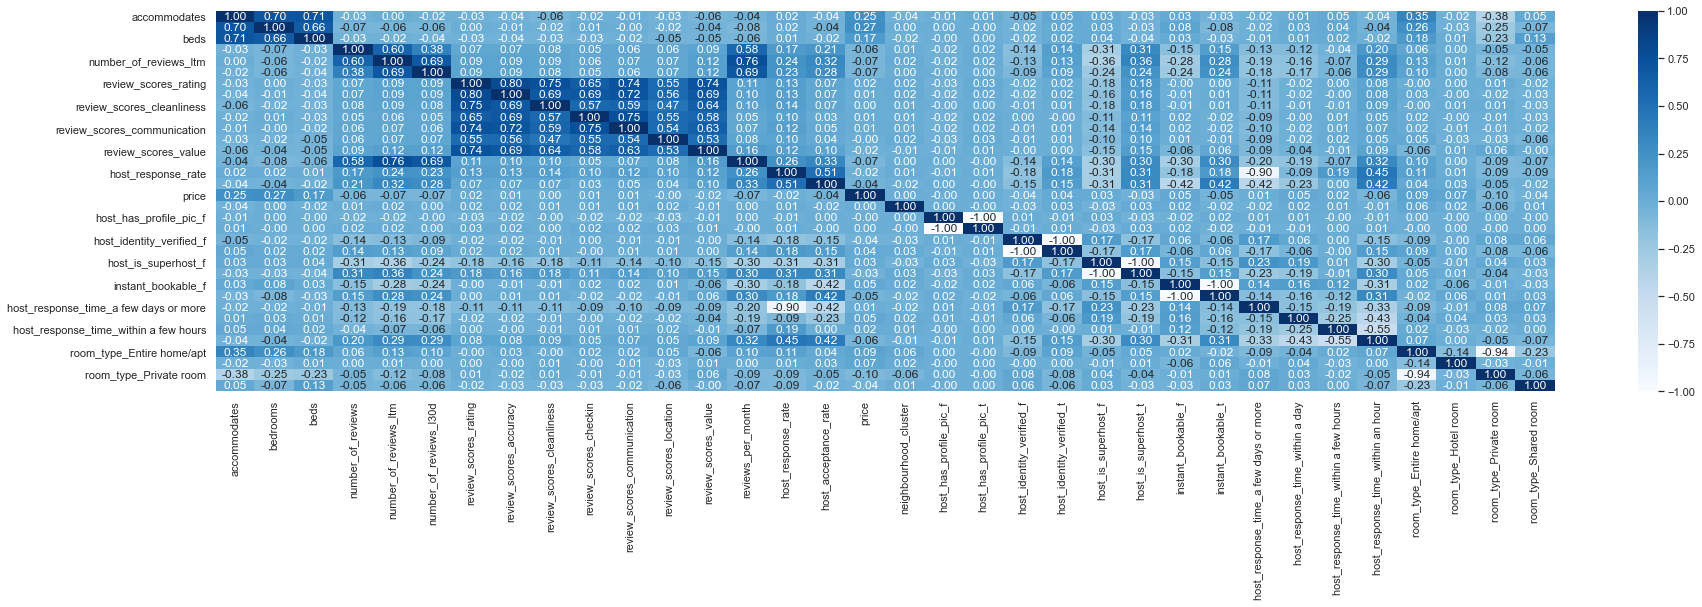

In [15]:
# Studying the correlation between features and price
plt.figure(figsize=(30,7))
sns.heatmap(list_df_selc_col.corr(), annot=True, cmap='Blues', fmt='.2f')
plt.show()

<font face = "Calibri"><font size=4>

The heatmap shows weak features correlation with price.  
Ideally, weak correlations won't contribute to predict well values of price.  
In a first moment, all columns are kept. But maybe a future good strategy might select columns with strong correlations.

In [26]:
# Predicting price

def model_price(df, col_target, test_split_size, random_state):
    '''
    INPUT
        df: dataframe with columns of features and target
        col_target: columns to fit model and predict
        test_split_size: the size of train/test dataset
        random_state: freeze state to repeat results
    OUTPUT
        r2_score: R² score for model
        cv_score: R² score for model using cross validation
        with 10 folds over test dataset
        feature_coefs_df: dataframe with features and coefs
        fitted in model
    '''
    # X and y datasets
    X = df.drop(col_target, axis=1)
    y = df[col_target]

    # Divide the training and test dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split_size, random_state=random_state)

    # Initiate a model
    model = LinearRegression(normalize=True)
    # Train model
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)

    # Result with r score
    r2 = r2_score(y_test,y_pred)
    print(f'Performance of model: {"{:.2f}%".format(r2*100)}' )

    # Result with cross validation
    cv_score = np.mean(cross_val_score(model,X_test, y_test, cv = 10))
    print(f'With cross validation: {"{:.2f}%".format(cv_score*100)}' ) 

    # Showing the coefficient of each feature used
    feature_coefs_df = pd.DataFrame({'Variable': X.columns, 'Coef': model.coef_}).sort_values('Coef', ascending=False).round(4)
    
    return r2, cv_score, feature_coefs_df

# Modeling
model_price(list_df_selc_col, 'price', 0.3, 15)[2]

Performance of model: 20.89%
With cross validation: -121356500293859344.00%


,Variable,Coef
18,host_has_profile_pic_t,3.005004e+16
17,host_has_profile_pic_f,3.005004e+16
30,room_type_Hotel room,1.924623e+16
29,room_type_Entire home/apt,1.924623e+16
31,room_type_Private room,1.924623e+16
32,room_type_Shared room,1.924623e+16
20,host_identity_verified_t,7.559846e+15
19,host_identity_verified_f,7.559846e+15
23,instant_bookable_f,5.122948e+15
24,instant_bookable_t,5.122948e+15


<font face = "Calibri"><font size=4>

Not such a great result. Moreover, there's such mess inside prediction, as the large negative R² value shows in cross validation.  
The problem here could be the presence of outliers within data.

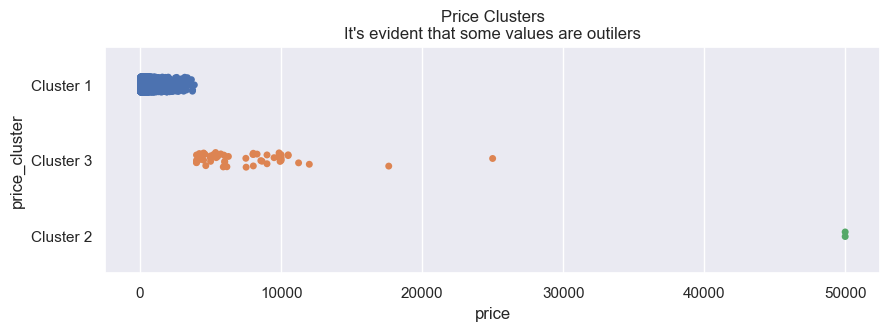

In [27]:
# Outlier’s visualization

# It's possible that some values of price are out of 
# normal range.
# So, it was decided to investigate this.
# This was made by creating cluster of prices.
# Using k_means from sklearn, price was sliced
price_cluster_df = list_df_selc_col[['price']]
price_cluster_df['price_cluster'] = k_means(price_cluster_df.values.reshape(-1, 1), n_clusters=3)[1]
price_cluster_df['price_cluster'] = price_cluster_df.price_cluster.map({0:'Cluster 1',1:'Cluster 2', 2:'Cluster 3'})

# Plotting the price by cluster
ax = sns.stripplot(data=price_cluster_df, x='price', y='price_cluster')
ax.set_title('Price Clusters\nIt\'s evident that some values are outilers')
ax.figure.set_size_inches(10,3)
ax.figure.set_dpi(100)
plt.show()

<font face = "Calibri"><font size=4>

Two accommodations have price nearly $ 50,000 in cluster 2. Something is not normal in these prices.  
For cluster 3, the values are quite normal. Two get away from others also, but nothing special.  
And cluster 1 is the rest values and doesn't show any strange dispersion.

So, for the next attempt, just cluster 1 is kept for a new try.

In [28]:
# Creating a table to observe the variance of values
price_cluster_values = price_cluster_df.groupby('price_cluster')['price'].describe().round(0)
price_cluster_values

,count,mean,std,min,25%,50%,75%,max
price_cluster,,,,,,,,
Cluster 1,9628.0,344.0,380.0,39.0,141.0,230.0,390.0,3846.0
Cluster 2,2.0,50000.0,0.0,50000.0,50000.0,50000.0,50000.0,50000.0
Cluster 3,55.0,7382.0,3653.0,4000.0,5000.0,6000.0,9250.0,25000.0


In [29]:
# To make easy regression and avoid working with outlier,
# values only inside cluster 1 was filter in original df
filter_cluster1 = price_cluster_values.loc['Cluster 1', 'max']
list_df_selc_col = list_df_selc_col.loc[list_df_selc_col.price <= filter_cluster1]

In [30]:
# Attempt 3 for modeling
model_price(list_df_selc_col, 'price', 0.3, 15)[2]

Performance of model: 33.37%
With cross validation: -34162770639996.27%


,Variable,Coef
18,host_has_profile_pic_t,4.052407e+15
17,host_has_profile_pic_f,4.052407e+15
26,host_response_time_within a day,1.231895e+15
27,host_response_time_within a few hours,1.231895e+15
28,host_response_time_within an hour,1.231895e+15
25,host_response_time_a few days or more,1.231895e+15
1,bedrooms,1.369222e+02
6,review_scores_rating,8.946840e+01
11,review_scores_location,7.877120e+01
0,accommodates,4.842180e+01


<font face = "Calibri"><font size=4>

R² scores is not so good yet and the strange value in cross validation is also present.  
Definitely, the model has low value for predicting.  
As said before, a good strategy might be to use for model just strong correlated features.

In [31]:
# One attempt is filter just features with
# significant correlation with price
col_w_corr = list_df_selc_col.corr()[['price']].\
                              drop('price').\
                              loc[lambda x: abs(x.price) > 0.1].\
                              index.values
# Creating a list of filtered columns from previous
# step and the price column
col_w_corr = np.append(col_w_corr, 'price')

In [32]:
# Filtering dataframe to selected columns
list_df_selc_col = list_df_selc_col.loc[:, col_w_corr]

# Attempt 2 of modeling
model_price(list_df_selc_col, 'price', 0.3, 15)[2]

Performance of model: 32.88%
With cross validation: 27.65%


,Variable,Coef
7,room_type_Entire home/apt,152.9950
1,bedrooms,140.1602
8,room_type_Private room,94.2821
0,accommodates,47.9454
3,number_of_reviews,-0.2838
4,number_of_reviews_ltm,-0.3721
5,number_of_reviews_l30d,-13.5922
6,reviews_per_month,-21.9509
2,beds,-22.9508


<font face = "Calibri"><font size=4>

This performance of prediction is considered not good.  
Just 33% of variance was gotten by model.  
But, at least, the cross validation score is consistent with overall result.  

Maybe new treatments could be done for features and it could improve results.

But interesting to observe the coefficient of each one.  

The feature room type has two categories in the top. The category Entire home/apt has the biggest coefficient. It is logical in generally. The bigger space the expensive. Besides, entire accommodation should be less expensive in comparison with shared rooms, as like for category Private room.  

Bedrooms contributes a lot for price. The more the more expensive. The divergent point is about number of beds. The model shows a negative relation between this and price. Maybe it is related with type of room. For singles, the room might be simpler than for couples. The number of singles beds are larger than couples’ ones.  

Lastly, the feature created lately which clusters neighborhoods by number of accommodations have weak influence, however, show that the more accommodations the price becomes more expensive. 
The motive could be that higher clusters have more famous Rio neighborhoods. Maybe this is the fact that people are more dedicated to put in AirBNB accommodation with high demand than others.
